In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import pandas as pd
import numpy as np

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, Linear
# impoort HeteroData
from torch_geometric.data import HeteroData


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from torch.nn import BCEWithLogitsLoss

import warnings
warnings.filterwarnings('ignore') 



/Users/bartoszlachowicz/Desktop/CodeProjects/GraphNeuralNetworks-ICAPS/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1


In [9]:
data = np.array([0.1,0.2,0.2,0.3])

true_data = np.array([0,1,1,1])

def treshhold_result(data, true_data, treshold):
    changed_data = (data >= treshold).astype(int)
    recall_positive = precision_recall_fscore_support(true_data, changed_data, average=None)[1][1] * 100
    recall_negative = precision_recall_fscore_support(true_data, changed_data, average=None)[1][0] * 100

    accuracy_positive = precision_recall_fscore_support(true_data, changed_data, average=None)[0][1] * 100
    accuracy_negative = precision_recall_fscore_support(true_data, changed_data, average=None)[0][0] * 100
 
    return recall_positive, recall_negative, accuracy_positive, accuracy_negative


def plot_recalls(treshold, result, bar_width):
    # bar_width = 0.005

    recall_positive = result[0]
    recall_negative = result[1]
    plt.title("Visualization of recall for positive and negative class")
    plt.legend(['Positive', 'Negative'], loc='best')
    plt.xlabel("Fixed treshold value")
    plt.ylabel("Recall %")

    plt.bar(treshold + bar_width/2, recall_positive, bar_width,  color='green', label='Positive')
    plt.bar(treshold - bar_width/2, recall_negative, bar_width, color='red', label='Negative')

def plot_accuracies(treshold, result, bar_width):
    # bar_width = 0.005

    recall_positive = result[0]
    recall_negative = result[1]
    plt.title("Visualization of accuracy for positive and negative class")
    plt.legend(['Positive', 'Negative'], loc='best')
    plt.xlabel("Fixed treshold value")
    plt.ylabel("Accuracy %")

    plt.bar(treshold + bar_width/2, recall_positive, bar_width,  color='green', label='Positive')
    plt.bar(treshold - bar_width/2, recall_negative, bar_width, color='red', label='Negative')




def plot_all_recalls(data, bar_width):
    # f = plt.figure(figsize=(10, 5))

    # f.legend()
    # f.yticks(np.arange(0, 105, 5))

    for treshold, result in data.items():
        plot_recalls(treshold, result[0:2], bar_width)
    plt.grid(axis='y', alpha=0.4)
    plt.show()



def plot_all_accuracies(data, bar_width):
    # f = plt.figure(figsize=(10, 5))

    # f.legend()
    # f.yticks(np.arange(0, 105, 5))

    for treshold, result in data.items():
        plot_accuracies(treshold, result[2:], bar_width)
    plt.grid(axis='y', alpha=0.4)
    plt.show()

# result_01 = treshhold_result(data, true_data, 0.1)
# result_02 = treshhold_result(data, true_data, 0.2)
# result_03 = treshhold_result(data, true_data, 0.3)

# print(f"Recall for treshold 0.1: {result_01}")
# print(f"Recall for treshold 0.2: {result_02}")
# print(f"Recall for treshold 0.3: {result_03}")

# data = {
#     0.1: result_01,
#     0.2: result_02,
#     0.3: result_03
# }

# plot_all_recalls(data, 0.005)

In [10]:
[1.2,3]+ [1,2,3,4,5,]

[1.2, 3, 1, 2, 3, 4, 5]

In [11]:
def node_df_to_torch(df: pd.DataFrame):
    return torch.tensor(df.values, dtype=torch.float)

def edge_df_to_torch(df: pd.DataFrame):
    # assert edge_type in ["VarVal","ValOp", "OpVal"]
        return torch.tensor(df.index, dtype=torch.long).t().contiguous()

def problem_dfs(problem_path):
    """
    Returns the dataframes for the variables, values, operators, and their respective edges
    """
    variables_df = pd.read_csv(os.path.join(problem_path, 'variables.csv'), index_col=0)
    variables_df = variables_df.drop(columns=["is_goal"])
    
    values_df = pd.read_csv(os.path.join(problem_path, 'values.csv'), index_col=0)

    operators_df = pd.read_csv(os.path.join(problem_path, 'operators.csv'), index_col=0)

    val_var_df = pd.read_csv(os.path.join(problem_path, 'ValVar_edges.csv'), index_col=[0,1])
    val_op_df = pd.read_csv(os.path.join(problem_path, 'ValOp_edges.csv'), index_col=[0,1])
    val_op_df = val_op_df.drop(columns=["label"])
    op_val_df = pd.read_csv(os.path.join(problem_path, 'OpVal_edges.csv'), index_col=[0,1])
    op_val_df = op_val_df.drop(columns=["label"])

    return variables_df, values_df, operators_df, val_var_df, val_op_df, op_val_df

def build_hetero(
    variables_df,
    values_df,
    operators_df,
    val_var_df,
    val_op_df,
    op_val_df,
):
    hetero_data = HeteroData()
    hetero_data['variable'].x = node_df_to_torch(variables_df)
    hetero_data['value'].x = node_df_to_torch(values_df)
    hetero_data['operator'].x = x = torch.empty(len(operators_df), 0)
    hetero_data['operator'].y = node_df_to_torch(operators_df)

    hetero_data['variable', 'has_value', 'value'].edge_index = edge_df_to_torch(val_var_df)
    hetero_data['value', 'precondition', 'operator'].edge_index = edge_df_to_torch(val_op_df)
    hetero_data['operator', 'effect', 'value'].edge_index = edge_df_to_torch(op_val_df)

    # VarVal = edge_df_to_torch(val_var_df)
    # ValOp = edge_df_to_torch(val_op_df)
    # OpVal = edge_df_to_torch(op_val_df)


    # return hetero_data
    return T.ToUndirected()(hetero_data)


def build_data_set():
    path = "big_dataset/satellite" 
    dataset = []
    dir_list = os.listdir(path)
    # print(dir_list)
    # dir_list = ['p907_4_2_2_7_3']*3
    # dir_list = os.listdir(path)
    for problem in dir_list:
        dfs = problem_dfs(os.path.join(path, problem))
        var_df, val_df, op_df, val_var_df, val_op_df, op_val_df = dfs
        temp_date = build_hetero(*dfs)
        dataset.append(temp_date)
    # dfs = problem_dfs(problem_path="z_test_data")
    # var_df, val_df, op_df, val_var_df, val_op_df, op_val_df = dfs
    # temp_date = build_hetero(*dfs)
    # dataset.append(temp_date)
    return dataset


def split_and_out_data_laoder(only_test=False):
    dataset = build_data_set()
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split_train = int(np.floor(0.7 * dataset_size))
    split_test = int(np.floor(0.2 * dataset_size))
    np.random.shuffle(indices)
    train_indices, test_indicies, validation_indicies = indices[:split_train], indices[split_train:split_train+split_test], indices[split_train+split_test:]
    
    assert len(train_indices) + len(test_indicies) + len(validation_indicies) == dataset_size
    train_set = []
    test_set = []
    val_set = []


    for i in train_indices:
        train_set.append(dataset[i])
    for i in test_indicies:
        test_set.append(dataset[i])
    
    for i in validation_indicies:
        val_set.append(dataset[i])
    
    if only_test:
        test_set = test_set + val_set
        
    

    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    # test_loader = train_loader
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)
    # test_loader = test_set
    val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=True)

    if only_test:
        val_loader = test_loader

    return train_loader, test_loader, val_loader

def dataset_metrics(dataset):

    total_positives = 0
    total_negatives = 0
    total_samples = 0
    for d in dataset:
        positives = d['operator'].y.count_nonzero()
        
        negatives = d['operator'].y.shape[0] - positives
        total = d['operator'].y.shape[0]

        total_positives += positives
        total_negatives += negatives
        total_samples += total
        assert positives + negatives == total
    
    assert total_positives + total_negatives == total_samples

    return total_positives, total_negatives, total_samples

total_positives, total_negatives, total_samples = dataset_metrics(build_data_set())


In [12]:
train_loader, test_loader, val_loader = split_and_out_data_laoder(only_test=True)

def gat_model_net(hidden_size):
    class GNN(torch.nn.Module):
        def __init__(self, out_channels):
            super().__init__()
            self.conv1 = GATConv((-1, -1), hidden_size, add_self_loops=False)
            self.conv2 = GATConv((-1, -1), hidden_size//2, add_self_loops=False)
            self.conv3 = GATConv((-1, -1), hidden_size//4, add_self_loops=False)
            self.output = GATConv((-1, -1), out_channels, add_self_loops=False)


        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = self.conv3(x, edge_index)
            x = x.relu()
            x = self.output(x, edge_index)
            x = x.sigmoid()
            return x


    model = GNN(out_channels=1)
    model = to_hetero(model, next(iter(train_loader)).metadata(), aggr='sum')
    optimizer = torch.optim.Adam(model.parameters())
    return optimizer, model

def sage_model_net(hidden_size=64):
    class GNN(torch.nn.Module):
        def __init__(self, out_channels):
            super().__init__()
            self.conv1 = SAGEConv((-1, -1), hidden_size)
            self.conv2 = SAGEConv((-1, -1), hidden_size//2)
            self.conv3 = SAGEConv((-1, -1), hidden_size//4)
            self.output = SAGEConv((-1, -1), out_channels)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = self.conv3(x, edge_index)
            x = x.relu()
            x = self.output(x, edge_index)
            x = x.sigmoid()
            return x


    model = GNN(out_channels=1)
    model = to_hetero(model, next(iter(train_loader)).metadata(), aggr='sum')
    optimizer = torch.optim.Adam(model.parameters())
    return optimizer, model

In [14]:
optimizer, model = sage_model_net()

# pos_weight = 1/ (total_positives / total_samples)
# neg_weight = 1/ (total_negatives / total_samples)

pos_weight = 1
neg_weight = 1

def test_val_results(batch):
    """returns loss, preds, original"""
    test_val_weights = torch.ones_like(batch['operator'].y)
    test_val_weights[batch['operator'].y == 0] = neg_weight
    test_val_weights[batch['operator'].y == 1] = pos_weight

    out = model(batch.x_dict, batch.edge_index_dict)
    # BCEWithLogitsLoss = torch.nn.BCEWithLogitsLoss()
    loss = F.binary_cross_entropy(out['operator'],
                                batch['operator'].y, weight=test_val_weights)
    original = batch['operator'].y
    preds = out['operator']
    return loss, preds, original

def train():
    model.train()

    for batch in train_loader:

        train_weights = torch.ones_like(batch['operator'].y)
        train_weights[batch['operator'].y == 0] = neg_weight
        train_weights[batch['operator'].y == 1] = pos_weight
        optimizer.zero_grad()
        out = model(batch.x_dict, batch.edge_index_dict)
        # metric_loss = torch.nn.BCEWithLogitsLoss()
        # loss = metric_loss(out['operator'], batch['operator'].y)
        loss = F.binary_cross_entropy(out['operator'],
                               batch['operator'].y,weight=train_weights)
        loss.backward()
        optimizer.step()
    # loss, pred, original
    return loss, out["operator"], batch['operator'].y

@torch.no_grad()
def test():
    model.eval()
    test_batch = next(iter(test_loader))
    val_batch = next(iter(val_loader))
    return test_val_results(test_batch), test_val_results(val_batch)



def evaluate_and_return_confusion():
    model.eval()
    targets = []
    preds = []
    for batch in test_loader:
        out = model(batch.x_dict, batch.edge_index_dict)
        target = batch['operator'].y
        pred = out['operator']
        targets.append(target)
        preds.append(pred)
    return targets, preds


In [15]:
LOG_PRECISION_RECALL = '        {:s}:    Precision: {:.4f}, Recall: {:.4f}'
LOG_LOSS = '    {:s}:, Loss: {:.4f}'


def get_pred_trues_and_negs(predicted, original):
    org_trues = original.count_nonzero()
    org_negs = len(original) - org_trues
    pred_trues = predicted.round().count_nonzero()
    pred_negs = len(predicted) - pred_trues
    return (pred_trues, pred_negs, org_trues, org_negs)


best_val_perf = test_perf = 0
epoch_list = []
train_loss_list, test_perf_list, val_perf_list = [], [], [] 
target_conf = []
preds_conf = []
for epoch in range(1, 300):
    train_loss, train_pred, train_original = train()
    (test_loss, test_pred, test_original), (val_loss, val_pred, val_original) = test()

    train_pred_trues, train_pred_negs, train_org_trues, train_org_negs = get_pred_trues_and_negs(train_pred, train_original)
    test_pred_trues, test_pred_negs, test_org_trues, test_org_negs = get_pred_trues_and_negs(test_pred, test_original)
    val_pred_trues, val_pred_negs, val_org_trues, val_org_negs = get_pred_trues_and_negs(val_pred, val_original)

    assert len(train_pred) == len(train_original)
    assert len(test_pred) == len(test_original)
    assert len(val_pred) == len(val_original)



    print(f"Epoch: {epoch}")

    epoch_list.append(epoch)
    train_loss_list.append(train_loss.item())
    test_perf_list.append(test_loss.item())
    val_perf_list.append(val_loss.item())
    


    if epoch % 1 == 0:
        train_rounded_pred = train_pred.round().detach().numpy()
        test_rounded_pred = test_pred.round().detach().numpy()
        val_rounded_pred = val_pred.round().detach().numpy()

        print(LOG_LOSS.format("Train", train_loss))

        def print_precision_recall(preds, originals):
            print()
            print(f"        Neg:    Predicted: {train_pred_negs}, Actual: {train_org_negs}")
            print(f"        Pos:    Predicted: {train_pred_trues}, Actual: {train_org_trues}")
        precision, recall, _, _ = precision_recall_fscore_support(
            y_pred=train_rounded_pred, y_true=train_original,  average=None)
        
        # print(log_precision_recall.format("Neg", precision[0], recall[0]))
        # print(log_precision_recall.format("Pos", precision[1], recall[1]))
        print(f"        Neg:    Precision: {precision[0]}, Recall: {recall[0]}")
        print(f"        Pos:    Precision: {precision[1]}, Recall: {recall[1]}")

        print(LOG_LOSS.format("Test", test_loss))
        precision, recall, _, _ = precision_recall_fscore_support(
            y_pred=test_rounded_pred, y_true=test_original,  average=None)
        print(f"        Neg:    Precision: {precision[0]}, Recall: {recall[0]}")
        print(f"        Pos:    Precision: {precision[1]}, Recall: {recall[1]}")

        # print(LOG_LOSS.format("Val", val_loss))
        # precision, recall, _, _ = precision_recall_fscore_support(
        #     y_pred=val_rounded_pred, y_true=val_original,  average=None)
        # print(f"        Neg:    Precision: {precision[0]}, Recall: {recall[0]}")
        # print(f"        Pos:    Precision: {precision[1]}, Recall: {recall[1]}")


Epoch: 1
    Train:, Loss: 0.1805
        Neg:    Precision: 0.948181049069374, Recall: 0.9997769848349688
        Pos:    Precision: 0.8666666666666667, Recall: 0.02584493041749503
    Test:, Loss: 0.2013
        Neg:    Precision: 0.9429164893411227, Recall: 0.9996744190816055
        Pos:    Precision: 0.7810344827586206, Recall: 0.018827930174563592
Epoch: 2
    Train:, Loss: 0.2000
        Neg:    Precision: 0.9363744604851912, Recall: 0.9992852604828463
        Pos:    Precision: 0.7692307692307693, Recall: 0.03389830508474576
    Test:, Loss: 0.1913
        Neg:    Precision: 0.9434388482937955, Recall: 0.9989463483664555
        Pos:    Precision: 0.6297297297297297, Recall: 0.029052369077306732
Epoch: 3
    Train:, Loss: 0.1575
        Neg:    Precision: 0.9511943189154293, Recall: 0.9999321343739396
        Pos:    Precision: 0.0, Recall: 0.0
    Test:, Loss: 0.1793
        Neg:    Precision: 0.9419013191732891, Recall: 0.9999769273364917
        Pos:    Precision: 0.0, Recal

In [ ]:
from torchmetrics.classification import BinaryConfusionMatrix

# target, preds = test()
# target_conf.append(target)
# preds_conf.append(preds)

(test_loss, test_preds, test_targets) , _ = test()


# target, pred = evaluate_and_return_confusion()


target_final = torch.tensor(test_targets)
preds_final = torch.tensor(test_preds)
metric = BinaryConfusionMatrix()
metric(preds_final, target_final)

tresholds = np.arange(0.1, 0.75, 0.05)

data = {}
for treshold in tresholds:
    result = treshhold_result(data = preds_final.numpy(), true_data=target_final.numpy(), treshold=treshold)
    data[treshold] = result
    
plt.plot()
plot_all_recalls(
    data,
    bar_width=0.005)

NameError: name 'test' is not defined

In [ ]:
plt.plot()
plot_all_accuracies(
    data,
    bar_width=0.005)

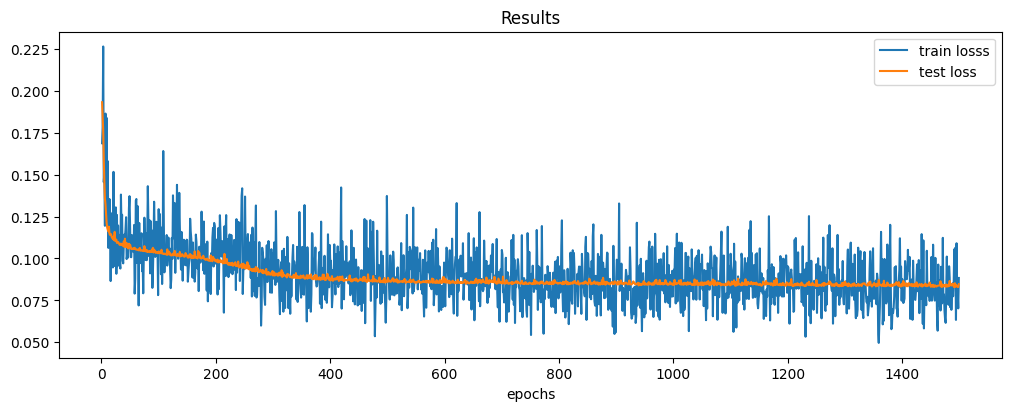

In [28]:

fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
ax.plot(epoch_list, train_loss_list, label='train losss')  
ax.plot(epoch_list, test_perf_list, label='test loss') 
# ax.plot(epoch_list, val_perf_list, label='val loss')
ax.set_xlabel('epochs')  
ax.set_title("Results") 
ax.legend()

In [20]:
metric = BinaryConfusionMatrix(treshold=0.5)

# print(preds_final.count_nonzero())
print(target_final.count_nonzero())
print(len(target_final) - target_final.count_nonzero())

metric(preds_final, target_final)

# precision_recall_fscore_support(preds_final, target_final, average=None)




tensor(24546)
tensor(380614)


tensor([[313472,  67142],
        [   259,  24287]])

In [ ]:
preds_final.round().count_nonzero()

tensor(110557)

In [ ]:
confusion_matrix(target_final, target_final)

array([[103909,      0],
       [     0,   6648]])

In [ ]:
test_set_size = len(targets)
print(f"test set size: {test_set_size}")
trues = targets.sum()

print(f"trues: {trues/test_set_size}")

ones = (targets == 1).sum()
print(f"ones: {ones/test_set_size}")


pred_test_size = len(preds)
print(f"pred test set size: {pred_test_size}")
pred_trues = preds.sum()
print(f"pred trues: {pred_trues/pred_test_size}")

test set size: 110557
trues: 0.06013187766075134
ones: 0.06013187766075134
pred test set size: 110557
pred trues: 0.9221007227897644


In [ ]:
test_loader

In [ ]:
# import torch.nn.functional as F

# def train():
#     for i in range(1, 100):
#         if i % 10 == 0:
#             print(f'Epoch: {i:03d}, Loss: {loss:.4f}')
#         model.train()
#         optimizer.zero_grad()
#         out = model(our_data.x_dict, our_data.edge_index_dict)

#         pred = out['operator']
#         true_label = our_data['operator'].y

#         print(pred[0])
#         # print(true_label)
#         loss = F.binary_cross_entropy_with_logits(pred, true_label)
#         loss.backward()
#         optimizer.step()
#         # return float(loss)

# train()

In [ ]:
# model.eval()

# out = model(our_data.x_dict, our_data.edge_index_dict)
# out["variable"]